Exercice 1 : Feature selection

1/ Après avoir découpé le dataset en train et en test, afficher la matrice de corrélation sur 
l’ensemble de train. Assurez-vous que la carte de chaleur dans l’intervalle [-1, 1]. Analysez 
cette matrice : Qu’en déduisez-vous en termes de sélection de features ?

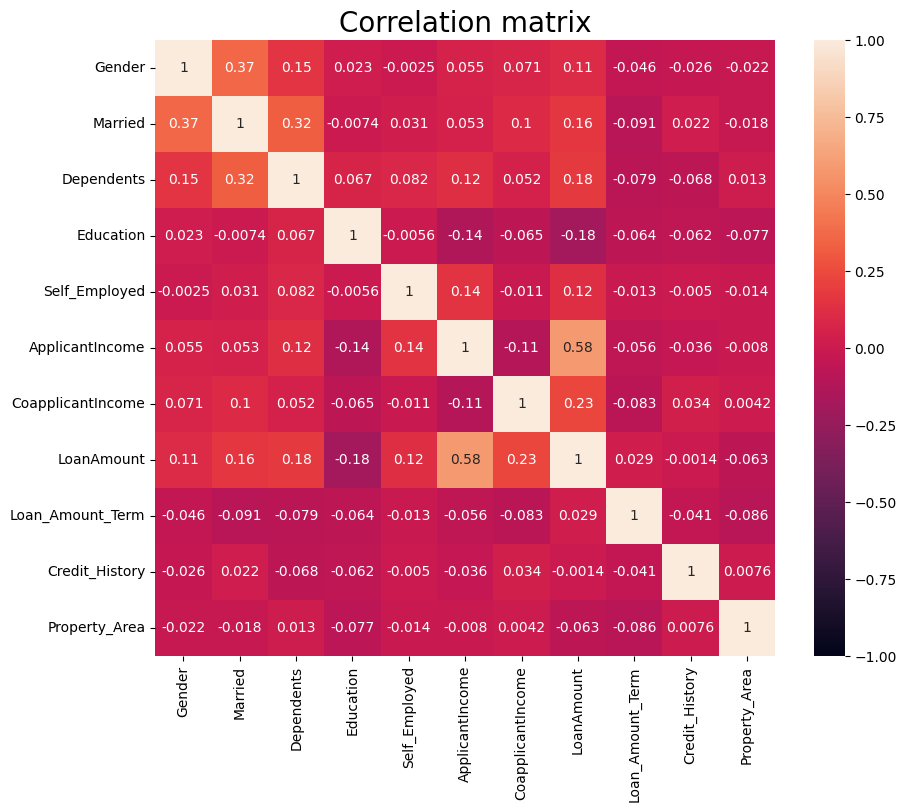

In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

random_state = 0
file = pd.read_csv("credit.csv").drop(columns=["Loan_ID"])


# Discriminate categorical features and numerical features
cat_col = file.select_dtypes(include="object").columns.tolist() + ["Credit_History"]
num_col = file.select_dtypes(exclude="object").columns.tolist()
num_col.remove("Credit_History")


# Transform categorical features to integer array
enc = OrdinalEncoder()
file[cat_col] = enc.fit_transform(file[cat_col])

# Fill missing values
imputer = KNNImputer()
imputer.set_output(transform="pandas")
file = imputer.fit_transform(file)
file[cat_col] = file[cat_col].round()  # .astype(int)  # Especially important

# Standardize numerical features
sts = StandardScaler()
file[num_col] = sts.fit_transform(file[num_col])

# print(file.dtypes)

X = file.iloc[:, :-1]
y = file.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    pd.DataFrame(X_train, columns=X_train.columns.tolist()).corr(),
    vmin=-1,
    annot=True,
)
plt.title("Correlation matrix", fontsize=20)
plt.show()

2/ A présent, utiliser Boruta avec un RandomForestClassifier pour sélectionner 
automatiquement les features importantes. Combien et quelles sont les features 
sélectionnées ?

In [160]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from boruta import BorutaPy


def optimize_hyperparameters(X, y, estimator, param_distributions):
    randomized_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_distributions,
        scoring="accuracy",
        n_jobs=-1,
        cv=5,
        random_state=random_state,
    )
    randomized_search.fit(X, y)
    print(randomized_search.best_params_)
    return randomized_search


def select_features(X, y, estimator):
    feat_selector = BorutaPy(
        estimator=estimator,
        n_estimators="auto",
        max_iter=10,
    )
    feat_selector.fit(X.values, y.values)

    print("\n------Support and Ranking for each feature------")
    for i in range(len(feat_selector.support_)):
        if feat_selector.support_[i]:
            print(
                "Passes the test: ",
                X.columns[i],
                " - Ranking: ",
                feat_selector.ranking_[i],
            )
        else:
            print(
                "Doesn't pass the test: ",
                X.columns[i],
                " - Ranking: ",
                feat_selector.ranking_[i],
            )
    return X.loc[:, feat_selector.support_]


param_distributions = {
    "n_estimators": [int(x) for x in np.linspace(start=10, stop=500)],
    "criterion": ["gini", "entropy"],
    "max_depth": [None] + [int(x) for x in np.linspace(start=1, stop=100)],
    "min_samples_split": [int(x) for x in np.linspace(start=2, stop=50)],
    "min_samples_leaf": [int(x) for x in np.linspace(start=1, stop=50)],
    "max_features": [None, "sqrt", "log2"],
    "bootstrap": [True, False],
}

rf = RandomForestClassifier(random_state=random_state)
rf.fit(X_train, y_train)

X_train_selected = select_features(
    X=X_train, y=y_train, estimator=RandomForestClassifier(class_weight="balanced")
)


------Support and Ranking for each feature------
Doesn't pass the test:  Gender  - Ranking:  9
Doesn't pass the test:  Married  - Ranking:  7
Doesn't pass the test:  Dependents  - Ranking:  5
Doesn't pass the test:  Education  - Ranking:  8
Doesn't pass the test:  Self_Employed  - Ranking:  10
Doesn't pass the test:  ApplicantIncome  - Ranking:  2
Doesn't pass the test:  CoapplicantIncome  - Ranking:  3
Doesn't pass the test:  LoanAmount  - Ranking:  2
Doesn't pass the test:  Loan_Amount_Term  - Ranking:  6
Passes the test:  Credit_History  - Ranking:  1
Doesn't pass the test:  Property_Area  - Ranking:  4


3/ Créer un nouveau dataset ne contenant que les features sélectionnées par Boruta. 
Réappliquez tout le pipeline de sélection de modèle sur ce nouveau dataset et comparez les 
résultats obtenus sur le dataset complet. Qu’en pensez-vous ?

{'n_estimators': 320, 'min_samples_split': 43, 'min_samples_leaf': 35, 'max_features': None, 'max_depth': 1, 'criterion': 'gini', 'bootstrap': False}


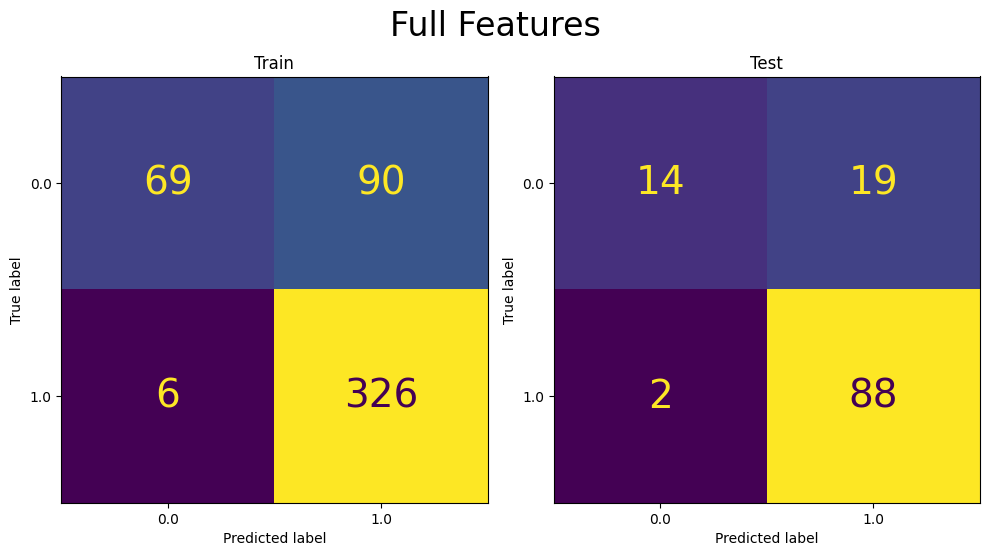

=== Classification Report: Full Features ===
              precision    recall  f1-score   support

         0.0       0.88      0.42      0.57        33
         1.0       0.82      0.98      0.89        90

    accuracy                           0.83       123
   macro avg       0.85      0.70      0.73       123
weighted avg       0.84      0.83      0.81       123

{'n_estimators': 190, 'min_samples_split': 44, 'min_samples_leaf': 24, 'max_features': None, 'max_depth': 95, 'criterion': 'entropy', 'bootstrap': False}


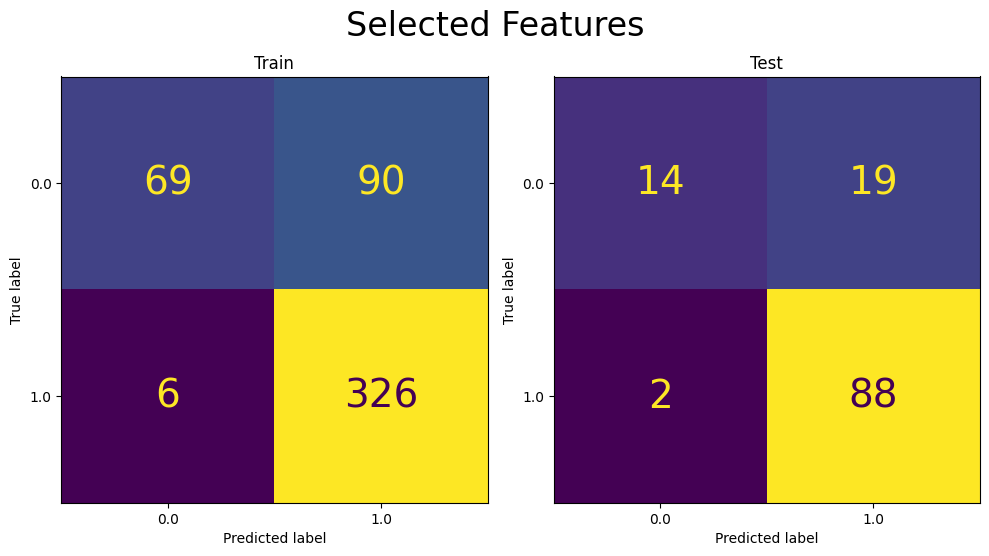

=== Classification Report: Selected Features ===
              precision    recall  f1-score   support

         0.0       0.88      0.42      0.57        33
         1.0       0.82      0.98      0.89        90

    accuracy                           0.83       123
   macro avg       0.85      0.70      0.73       123
weighted avg       0.84      0.83      0.81       123



In [161]:
from sklearn.metrics import classification_report


def plot_confusion_matrix(
    estimator, X_train, y_train, X_test, y_test, title="Confusion Matrix"
):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs = axs.flatten()

    ConfusionMatrixDisplay.from_estimator(
        estimator, X_train, y_train, ax=axs[0], text_kw={"fontsize": 28}, colorbar=False
    )
    ConfusionMatrixDisplay.from_estimator(
        estimator, X_test, y_test, ax=axs[1], text_kw={"fontsize": 28}, colorbar=False
    )

    axs[0].set_title("Train")
    axs[1].set_title("Test")
    plt.tight_layout()
    plt.suptitle(title, fontsize=24, y=0.78)
    plt.show()

    print(f"=== Classification Report: {title} ===")
    print(classification_report(y_test, estimator.predict(X_test)))


# Random forest with full dataset
rf_full = optimize_hyperparameters(
    X=X_train,
    y=y_train,
    estimator=RandomForestClassifier(class_weight="balanced"),
    param_distributions=param_distributions,
).best_estimator_
plot_confusion_matrix(rf_full, X_train, y_train, X_test, y_test, title="Full Features")


# Random forest with selected dataset
X_test_selected = X_test[X_train_selected.columns]
rf_simplified = optimize_hyperparameters(
    X=X_train_selected,
    y=y_train,
    estimator=RandomForestClassifier(class_weight="balanced"),
    param_distributions=param_distributions,
).best_estimator_
plot_confusion_matrix(
    rf_simplified,
    X_train_selected,
    y_train,
    X_test_selected,
    y_test,
    title="Selected Features",
)

Exercice 2 : Explicabilité

1/  En  partant  du  meilleur  modèle  obtenu  sur  le  dataset  complet  (qui  sera  plus  intéressant 
pour cet exercice sur l’explicabilité), afficher, analyser et expliquer un summary plot obtenu 
en utilisant les SHap Values.

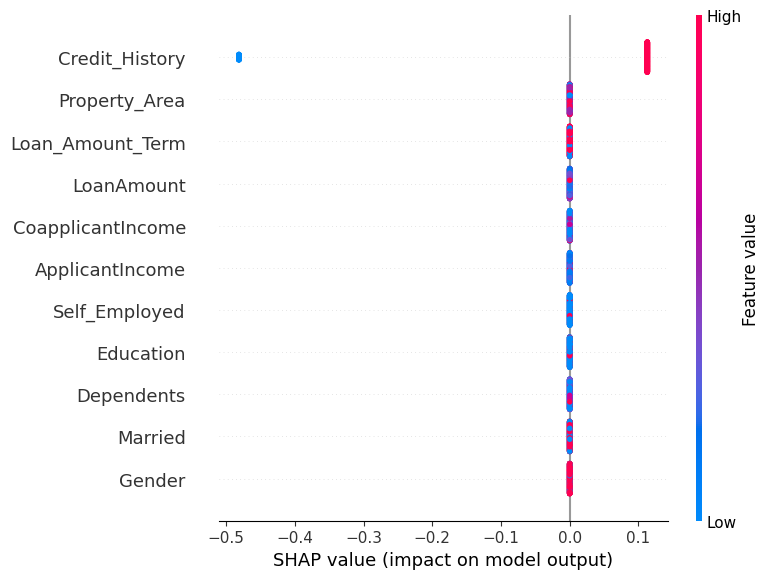

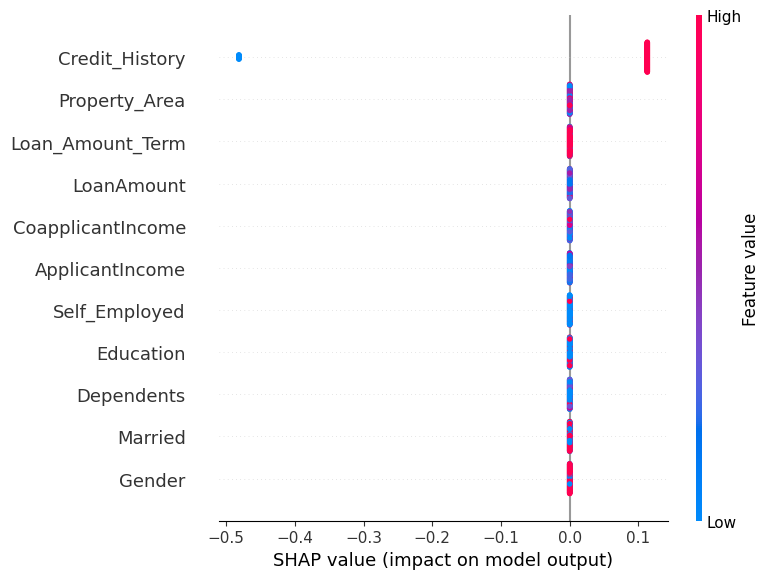

In [162]:
import shap


def explain(model, X_train, X_test):
    explainer = shap.TreeExplainer(model, X_train)
    shap_values_train = explainer(X_train, check_additivity=False)
    shap_values_test = explainer(X_test, check_additivity=False)

    shap.summary_plot(shap_values_train[:, :, 1], X_train)

    shap.summary_plot(shap_values_test[:, :, 1], X_test)


explain(
    model=rf_full,
    X_train=X_train,
    X_test=X_test,
)

2/ Afficher et analyser les ICE plots de chacune des features du dataset.

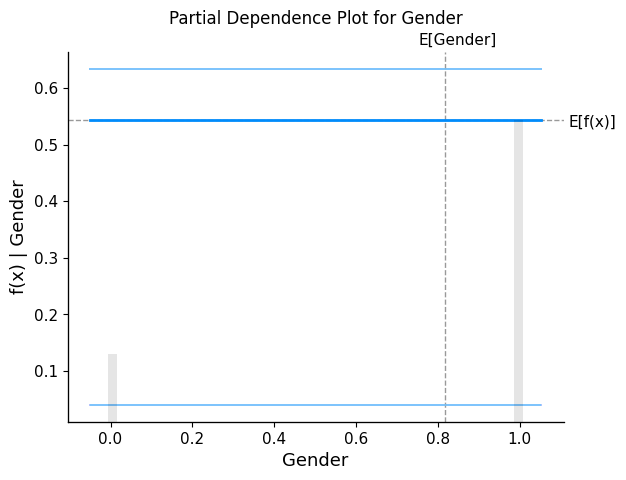

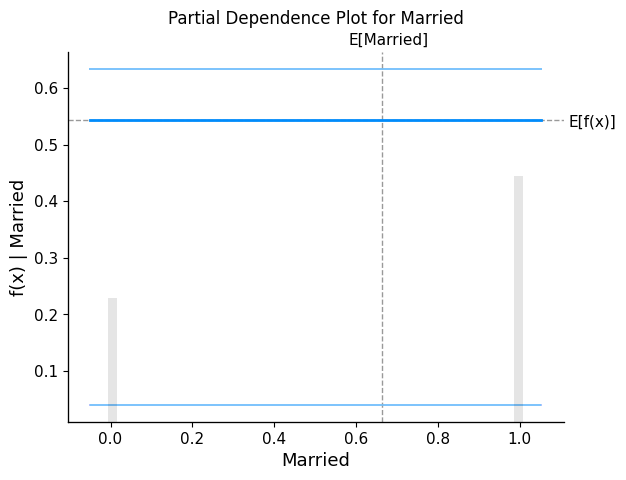

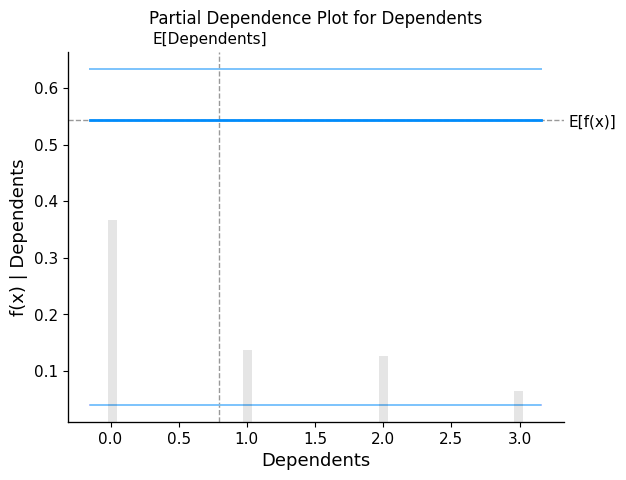

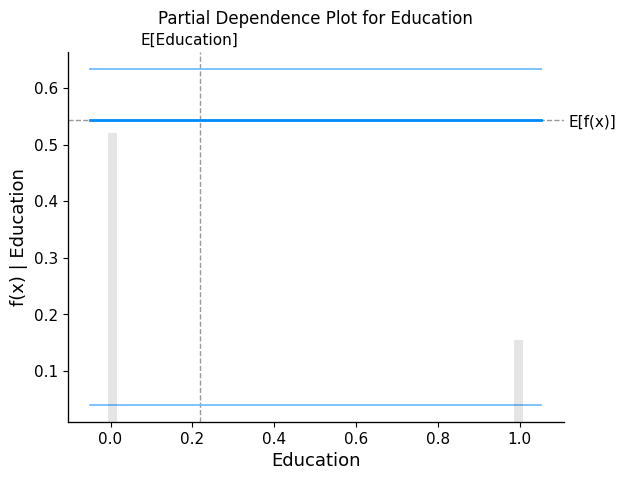

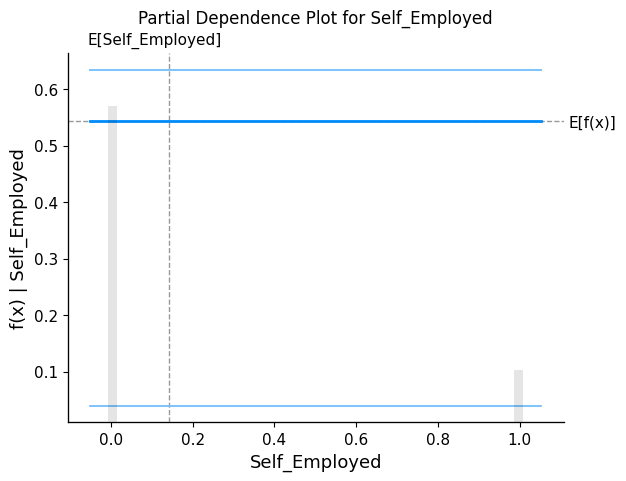

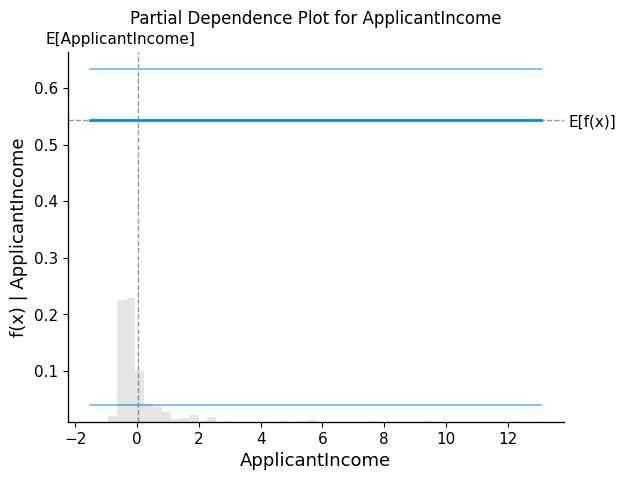

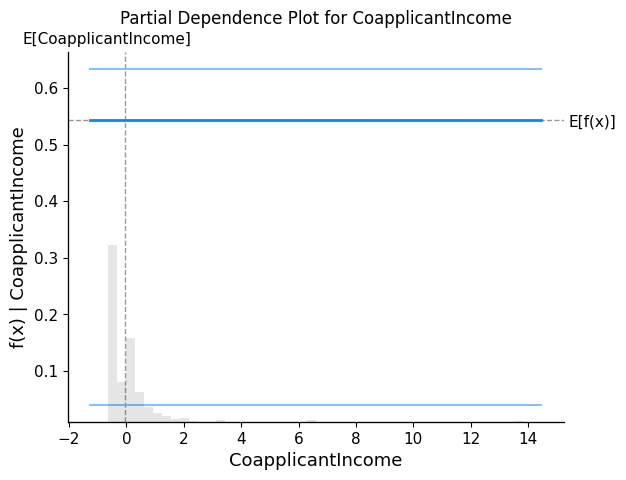

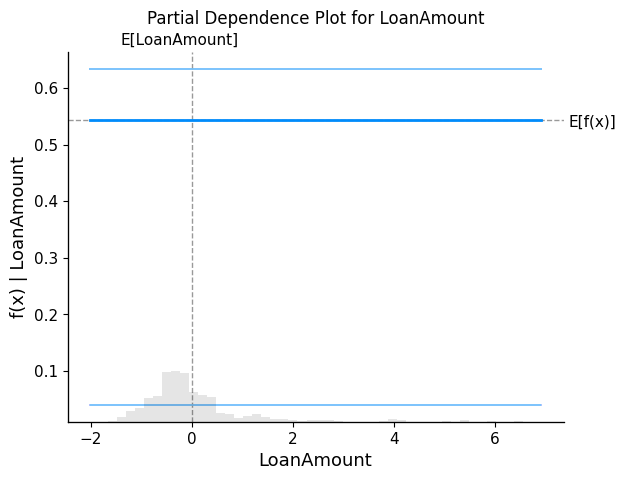

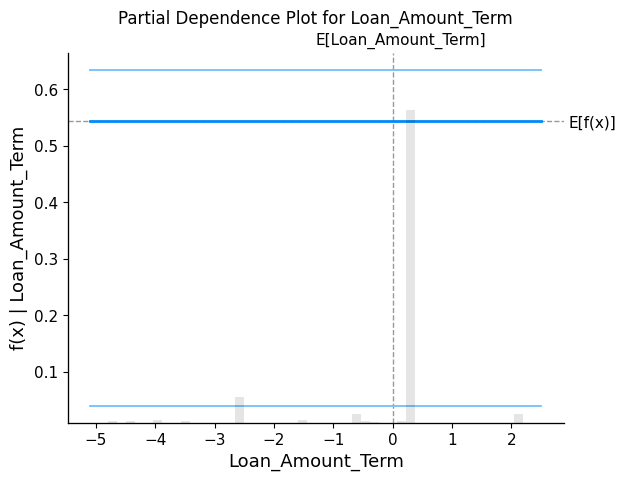

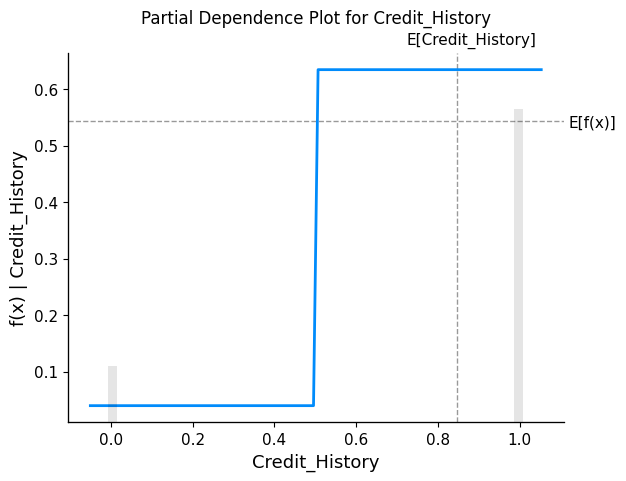

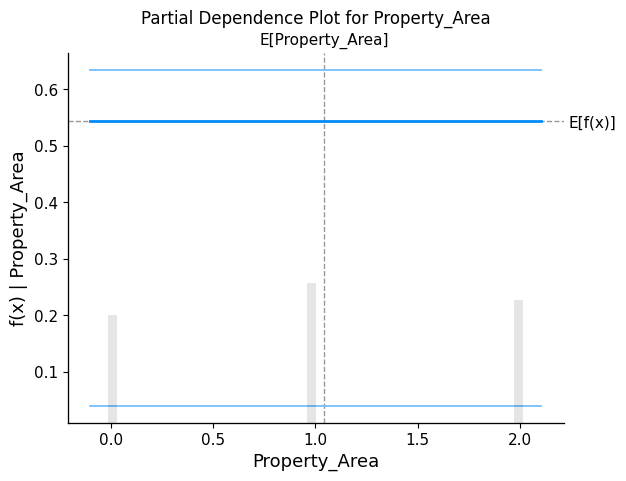

In [169]:
def plot_ICE(model, X):
    for i, feature in enumerate(X.columns.tolist()):
        shap.plots.partial_dependence(  # substitution for PartialDependenceDisplay.from_estimator()
            feature,
            lambda x: model.predict_proba(x)[:, 1],
            X,
            model_expected_value=True,
            feature_expected_value=True,
            show=False,
        )
        plt.title(f"Partial Dependence Plot for {feature}")
        plt.show()


plot_ICE(rf_full, X_train)

3/  Quelles  informations  sur  le  fonctionnement  du  modèle  tirez-vous  de  cette  analyse. 
Attention, chaque modèle peut avoir un fonctionnement différent ! 

- Matrice de confusion:
Les matrices de confusion du modèle d'entraînement et du modèle de test sont identiques, donc l'algorithme Boruta a réussi à simplifier le modèle sans diminuer les performances de prédiction.
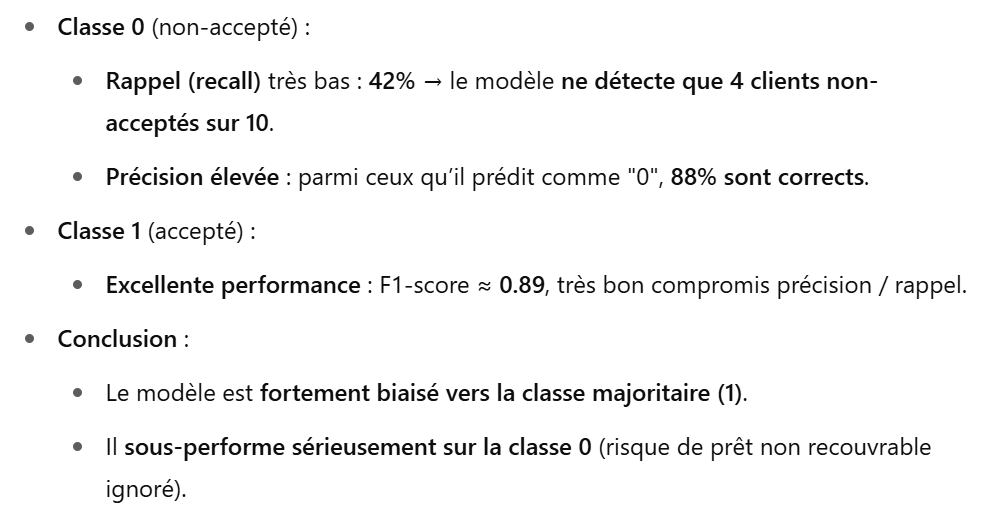
- summary_plot:
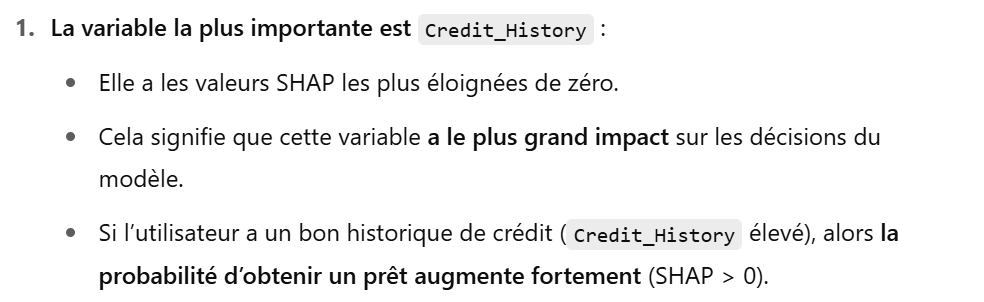
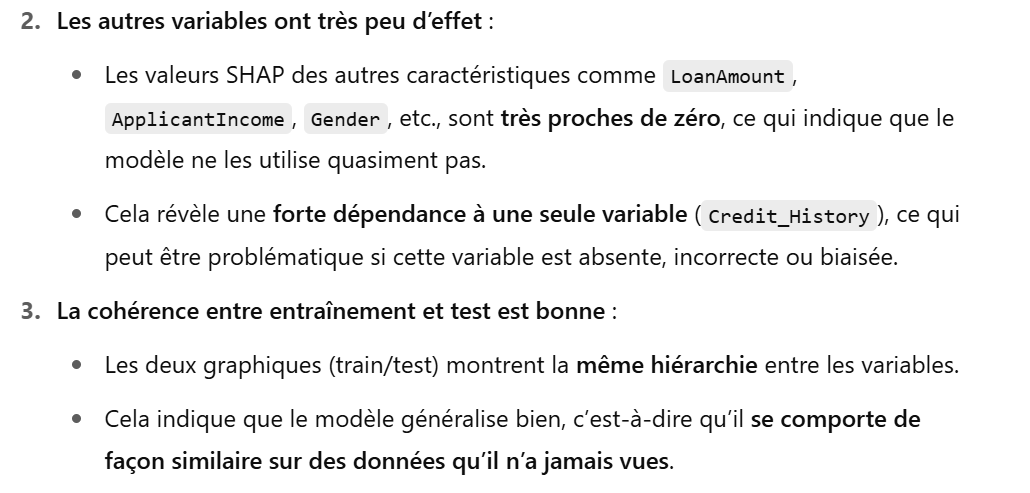
- Plot ICE
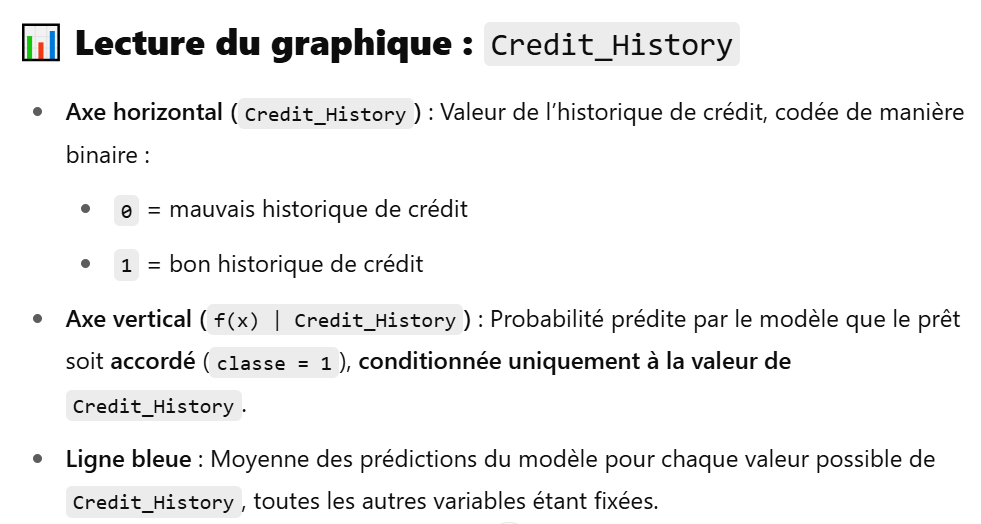
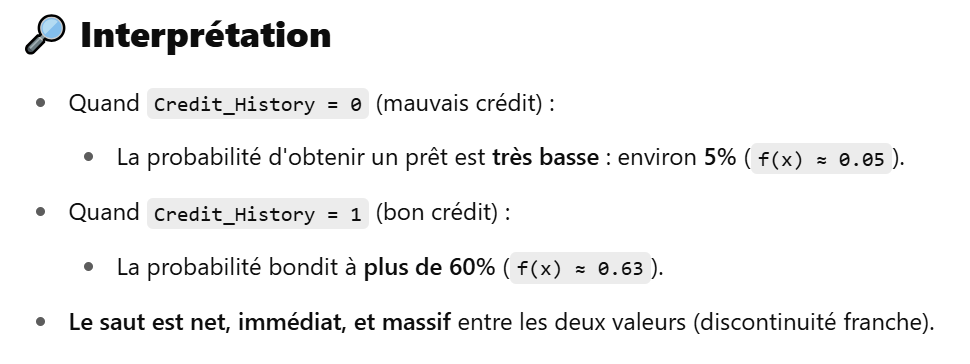

Exercice 3 : Ajout des derniers algorithmes de ML

1/ Ajouter et optimiser XGBoost à votre pipeline de sélection de modèles. En particulier, 
vous devriez évaluer différentes profondeurs maximales d’arbres (entre 3 et 10), différents 
nombres de pondérations par feuille (min_child_weight, entre 1 et 10), différentes valeurs 
de gamma (entre 0 et 5), différents taux d’apprentissage (entre 0.01 et 0.3) et différents 
nombres d’estimateurs (entre 25 et 200). Vous regarderez avant cela l’impact de ces 
paramètres sur l’apprentissage. 

{'n_estimators': 189, 'min_child_weight': 9, 'max_depth': 4, 'learning_rate': np.float64(0.16979591836734695), 'gamma': np.float64(3.36734693877551)}


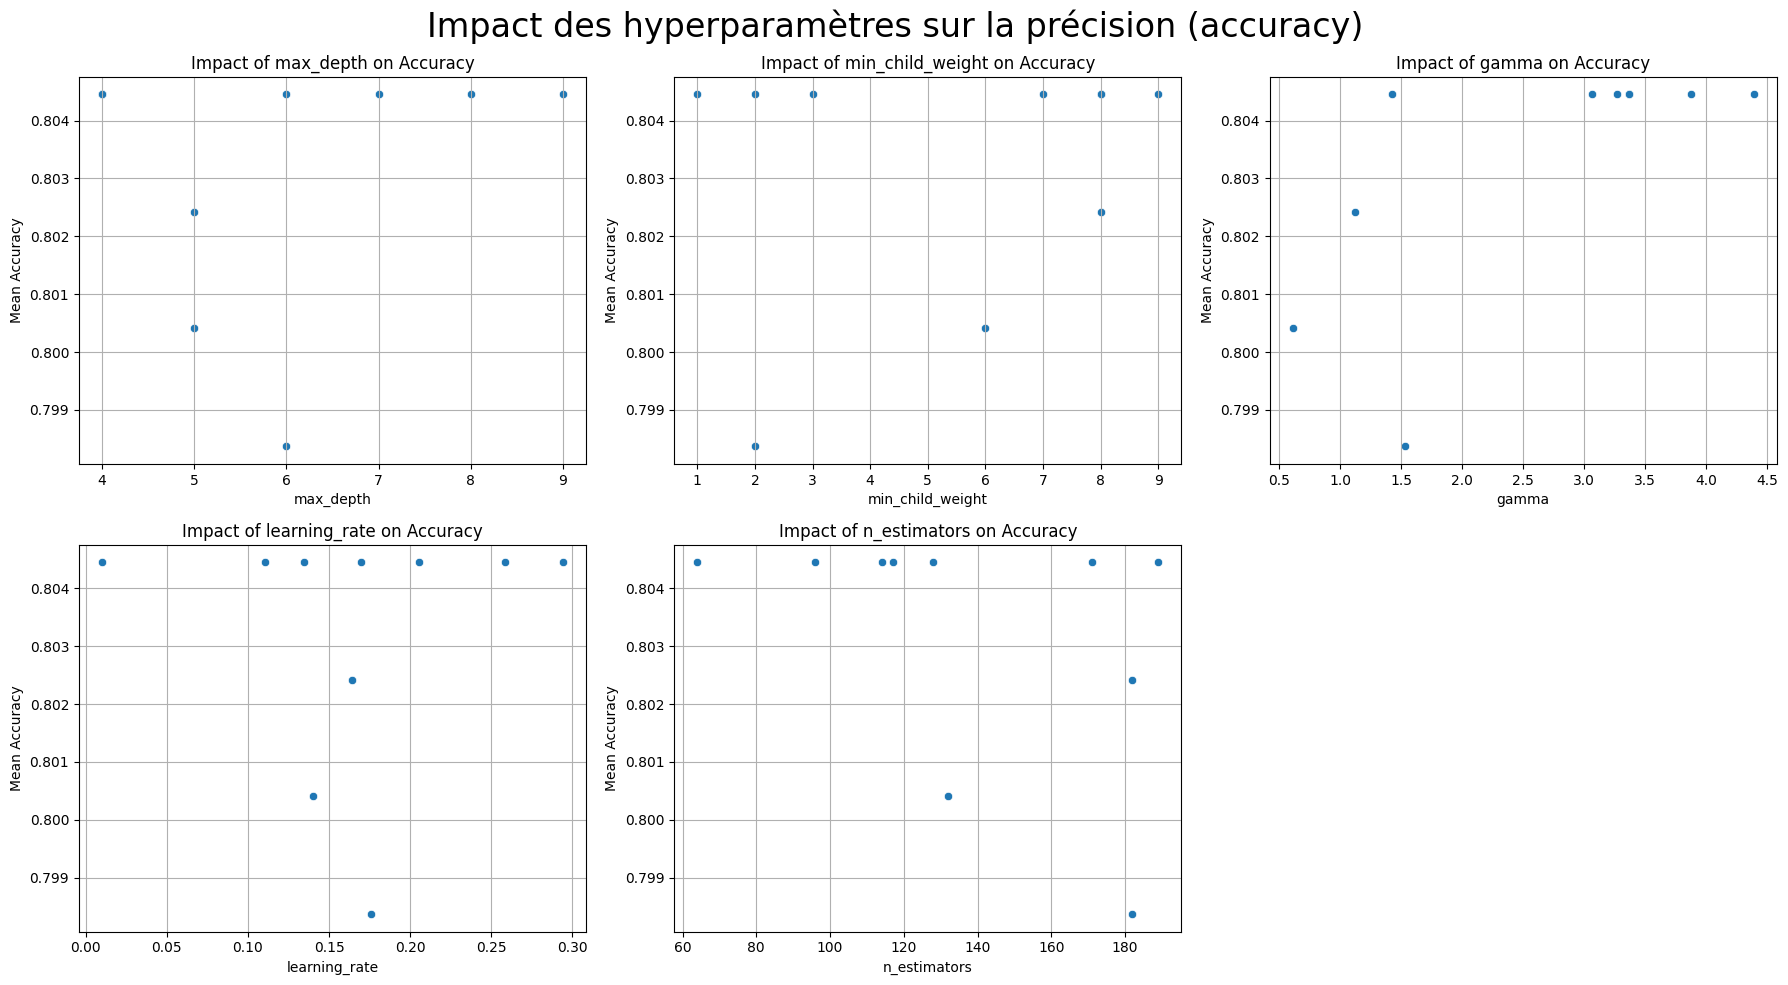

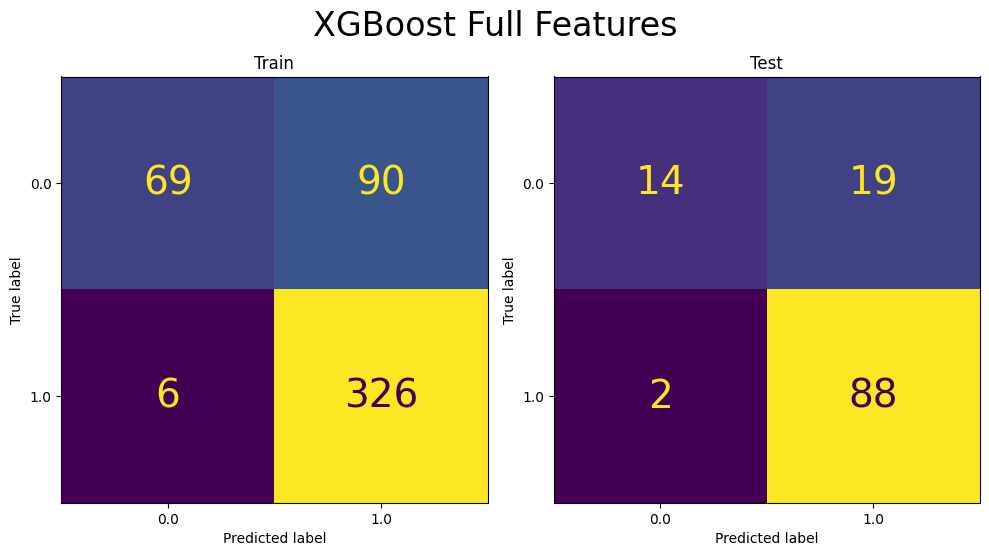

=== Classification Report: XGBoost Full Features ===
              precision    recall  f1-score   support

         0.0       0.88      0.42      0.57        33
         1.0       0.82      0.98      0.89        90

    accuracy                           0.83       123
   macro avg       0.85      0.70      0.73       123
weighted avg       0.84      0.83      0.81       123



In [164]:
from xgboost import XGBClassifier

param_distributions = {
    "max_depth": [int(x) for x in np.linspace(start=3, stop=10)],
    "min_child_weight": [int(x) for x in np.linspace(start=1, stop=10)],
    "gamma": [x for x in np.linspace(start=0, stop=5)],
    "learning_rate": [x for x in np.linspace(start=0.01, stop=0.3)],
    "n_estimators": [int(x) for x in np.linspace(start=25, stop=200)],
}

search_result = optimize_hyperparameters(
    X=X_train,
    y=y_train,
    estimator=XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=random_state,
    ),
    param_distributions=param_distributions,
)
cv_results = pd.DataFrame(search_result.cv_results_)

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, param in enumerate(param_distributions.keys()):
    sns.scatterplot(data=cv_results, x=f"param_{param}", y="mean_test_score", ax=axs[i])
    axs[i].set_title(f"Impact of {param} on Accuracy")
    axs[i].set_xlabel(param)
    axs[i].set_ylabel("Mean Accuracy")
    axs[i].grid(True)
fig.delaxes(axs[-1])
plt.suptitle("Impact des hyperparamètres sur la précision (accuracy)", fontsize=24)
plt.tight_layout()
plt.show()
model = search_result.best_estimator_


plot_confusion_matrix(
    model, X_train, y_train, X_test, y_test, title="XGBoost Full Features"
)

2/ Ajouter et tester différentes architectures de perceptron multicouche. Voici deux 
exemples à tester : 
- 2 couches cachées avec une fonction d’activation ReLU : 1ère de 64 neurones et 2nde 
de 32 neurones 
- 3 couches cachées avec une fonction d’activation ReLU : 1ère de 128 neurones, 2nde 
de 64 neurones et une 3ème de 32 neurones 
Vous pourrez tester toute autre architecture de votre choix.

c:\Users\zhubo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


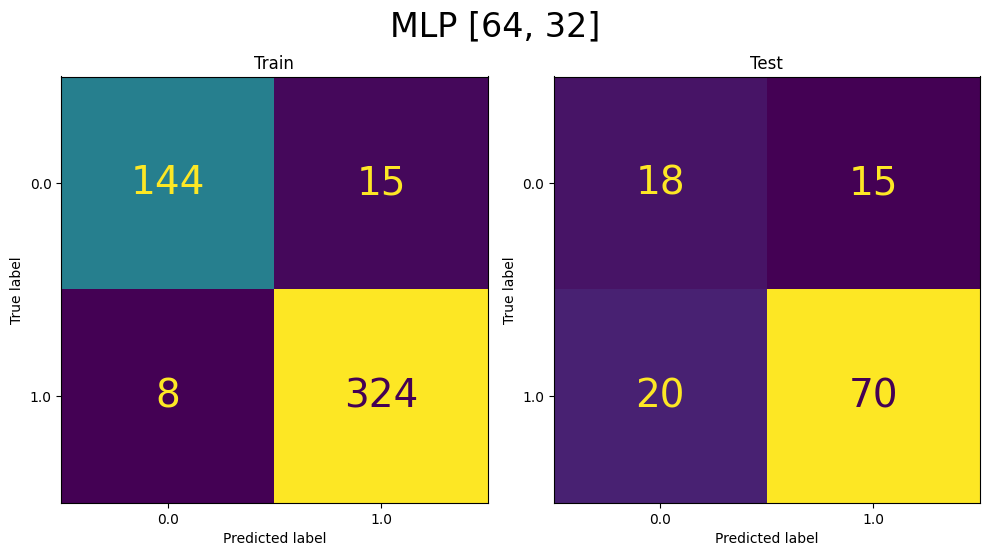

=== Classification Report: MLP [64, 32] ===
              precision    recall  f1-score   support

         0.0       0.47      0.55      0.51        33
         1.0       0.82      0.78      0.80        90

    accuracy                           0.72       123
   macro avg       0.65      0.66      0.65       123
weighted avg       0.73      0.72      0.72       123



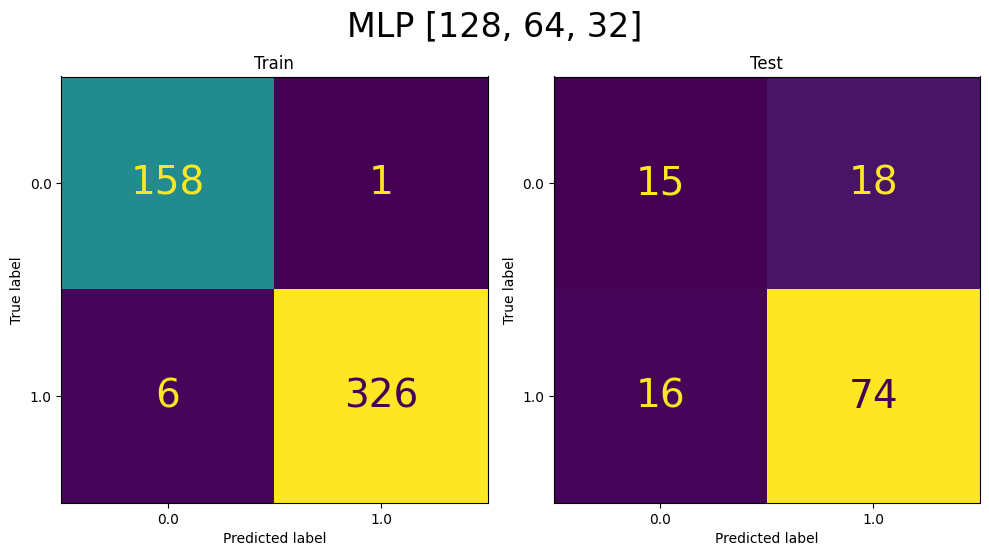

=== Classification Report: MLP [128, 64, 32] ===
              precision    recall  f1-score   support

         0.0       0.48      0.45      0.47        33
         1.0       0.80      0.82      0.81        90

    accuracy                           0.72       123
   macro avg       0.64      0.64      0.64       123
weighted avg       0.72      0.72      0.72       123



In [165]:
from sklearn.neural_network import MLPClassifier

mlp2 = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=random_state,
)
mlp3 = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=random_state,
)

models = {
    "MLP [64, 32]": mlp2,
    "MLP [128, 64, 32]": mlp3,
}

for name, model in models.items():
    model.fit(X_train, y_train)
    plot_confusion_matrix(model, X_train, y_train, X_test, y_test, title=name)

3/ Relancer votre pipeline sur le dataset et évaluer l’intérêt de ces nouveaux algorithmes 
pour ce dataset.

Exercice 4 : Construire un pipeline pour la régression (à faire à la 
maison)

Reprendre ce même travail pour un dataset de régression proposé en tronc commun 
(insurance).